<a href="https://colab.research.google.com/github/jypaeng/Machine-Learning-Deployment/blob/master/third_molar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


data :  /content/drive/My Drive/third_molar/third_molar_data_192.csv

image_folder : /content/drive/My Drive/third_molar/third_molar_images_flip_bright


seed= 0
batch_size =  8
epoch = 200
image_size = 256 X 256
test_size =  0.1
filters =  (16, 32, 64)


   no operator        date        ID  ... height weight        bmi  g_a
0   1        A  2020.03.05  25132686  ...    NaN    NaN        NaN    0
1   2        A  2020.03.06  43936178  ...    178   72.0  22.724403    0
2   3        A  2020.03.06  43557920  ...    175   71.0  23.183673    0
3   4        A  2020.03.06  43915276  ...    165   62.0  22.773186    0
4   5        K  2020.03.06  24816372  ...    185  105.0  30.679328    0

[5 rows x 21 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   no                  192 non-null    int64  
 1   operator            192 non-nul

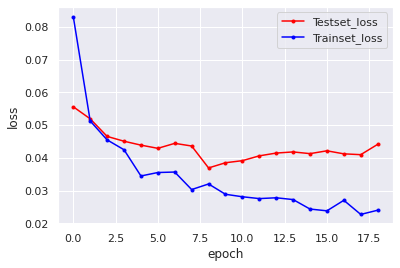



    real time  predicted time
0        11.0       12.871565
1         5.0       25.622055
2        16.0        7.007649
3         9.0       15.735139
4        10.0       23.597399
5        26.0       11.609874
6         8.0        9.767699
7        12.0       12.003328
8        14.0       16.251532
9         6.0        9.357512
10        6.0       11.357699
11       40.0       23.166229
12        7.0       11.145809
13        8.0       10.165686
14        9.0       10.464959
15        5.0       13.254407
16       20.0       23.831930
17       20.0       22.445765
18       40.0       21.105589
19       20.0       30.270538


r            =  0.4248200961931221
r2           =  0.11334578213948265
r-squared    =  0.1804721141295335
p-value      =  0.061888631124503324
rmse         =  9.627607799195939
mae          =  7.362684011459351
standard error :  0.13689022970046286
slope        =  0.27254102807987346
intercept    =  12.07251765873502
result_200614_070253_8


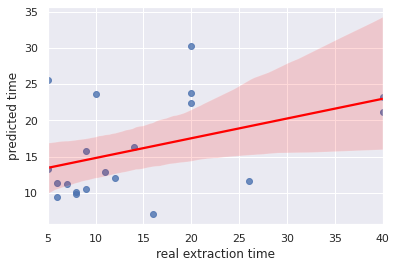

In [22]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline

import pandas as pd
import numpy as np
import glob
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#parameter
seed = 0
batch_size = 8
epoch = 200
w = 256
h = 256
test_size = 0.1
filters = (16, 32, 64)

#seed
seed = seed
np.random.seed(seed)
#tf.compat.v1.set_random_seed(seed)
tf.random.set_seed(seed)


#data source
main_dir = "/Users/paengmacbookpro13/Dropbox/python/third_molar/data/"
data_dir = "/content/drive/My Drive/third_molar/third_molar_data_192.csv"
img_dir = "/content/drive/My Drive/third_molar/third_molar_images_flip_bright"

#print of parameter
print("\ndata : ",data_dir)
print("\nimage_folder :", img_dir)
print("\n")
print("seed=", seed)
print("batch_size = ", batch_size)
print("epoch =", epoch)
print("image_size = {0} X {1}".format(w,h))
print("test_size = ", test_size)
print("filters = ", filters)
print("\n")

#csv 읽어오기
df_org = pd.read_csv(data_dir)
df=df_org.copy()
print(df.head())
print(df.info())


#plt.title('Original age Histogram')
#sns.distplot(df['age'])

#plt.title('Original time_min Histogram')
#sns.distplot(df['time_min'])

#plt.title('Original mmo Histogram')
#sns.distplot(df['mmo'])

print(df.groupby("ext_tooth").count())
print(df.groupby("sex").count())
print(df.groupby("operator").count())


df["location"]=df["ext_tooth"].replace([38,48],[0,1])
df["location"].head(5)

#변환할 dictionary map을 만든다.
mapping = {
  'P':24,
  'K':38,
  'A':10,
  'Y':2,
  'D':1
  }
#dict.get()을 이용하여 변환 함수 생성
func=lambda x:mapping.get(x,x)

#df의 변수에 적용
df['experience'] = df.operator.map(func)

# 불필요한 col 삭제
df=df.drop(["no","date","ID","name","ext_tooth","no_root",
            "collagen_plug","stitch","bone_quality","winter_index",
            "pell_gregory_index",
            "experience","weight","height","g_a"
               ,"difficulty_index"
            ],axis=1)

df_corr = df.drop(["operator"], axis=1)
corr = df.corr(method ='pearson')
print("\nCorrelation\n",corr)

#missing data의 visualization
#(1)
#import missingno as msno
#ax = msno.matrix(df)
#ax.get_figure().savefig("str")
#plt.show()
#(2)
#fig,ax = plt.subplots(figsize=(6,4))
#(1-df.isnull().mean()).abs().plot.bar(ax=ax)
#fig.savefig("", dpi=)
#plt.show()

#(3)
#ax=msno.bar(df)
#ax.get_figure().savefig("str")
#plt.show()

#
#ax=msno.heatmap(df,figsize=(6,6))
#ax.get_figure().savefig("str")
#plt.show()

#
#ax = msno.dendrogram(df)
#ax.get_figure().savefig("str")
#plt.show()

#imputing missing data
#from sklearn.impute import SimpleImputer
#im = SimpleImputer()
#imputed = im.fit_transform(df["bmi"])

df = df.fillna(df.mean())
df["location"] = df["location"].astype(str)

print('\ndf.head()\n', df.head())

#범주형 변수의 hot-one encoding
df_ohe=pd.get_dummies(df)
print("\ndf_ohe.head()\n",df_ohe.head())
print("\ndf_ohe.info()",df_ohe.info())

#from sklearn.impute import SimpleImputer
#mean_imputer = SimpleImputer(strategy='mean')
#df_ohe = mean_imputer.fit_transform(df_ohe)

#이미지 파일 불러오기
fname = os.listdir(img_dir)
fname = sorted(fname)
fname


img_paths=[]
for i in fname:
    img_path=os.path.join(img_dir,i)
    img_paths.append(img_path)

from keras.preprocessing import image
img_paths.remove(img_dir + '/.DS_Store')

images=[]
for i in img_paths:
    image = cv2.imread(i)
    image = cv2.resize(image, (w,h))
    images.append(image)

images = np.array(images)/255
#=============================================
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input, concatenate
from keras.utils import np_utils
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, Adagrad, RMSprop, Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
import locale

# MLP model =================================================================
def create_mlp(dim, regress=False):
    model = Sequential()
    model.add(Dense(16,
                    input_dim=dim,
                    kernel_regularizer=l2(0.001),      ##  0.001
                    activation="relu"))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1))

    return model

#CNN model ===================================================================
def create_cnn(width, height, depth, filters=filters, regress=False):
    inputShape = (height, width, depth)
    chanDim = -1
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x) #initial : 16
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    if regress:
        x = Dense(1)(x)

    model = Model(inputs, x)
    return model

# preprocessing =====================================================================
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

def process_ahi_attributes(df, train, test):
	# initialize the column names of the continuous data
	# performin min-max scaling each continuous feature column to the range [0, 1]
	cs = MinMaxScaler()
	trainX = cs.fit_transform(train)
	testX = cs.transform(test)

	return (trainX, testX)
#===========================================================
split = train_test_split(df_ohe, images, test_size=test_size, random_state=42)  #original 42
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

maxahi = trainAttrX["time_min"].max()
trainY = trainAttrX["time_min"]/maxahi
testY = testAttrX["time_min"]/maxahi

trainAttrX = trainAttrX.drop(["time_min"],axis=1)
testAttrX = testAttrX.drop(["time_min"],axis=1)

(trainAttrX, testAttrX) = process_ahi_attributes(df_ohe, trainAttrX, testAttrX)
#=====================================================
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1])
cnn = create_cnn(w, h, 3)

# create the input to our final set of layers as the *output* of both the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1)(x)
#===========================================================
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the predicted ahi)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# 모델 compile
adagrad1 = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss="mean_squared_error",
              optimizer=adagrad1,
              metrics=['mse'])

print("[INFO] training model...")
callbacks = [EarlyStopping(monitor="val_loss", patience = 10)
#                   ModelCheckpoint(filepath = "/Users/paengmacbookpro13/Dropbox/python/third_molar/best_model.h5"
#              , monitor="val_loss",
#              save_best_only=True)
              ]
history = model.fit([trainAttrX,trainImagesX], trainY,
                    validation_data=([testAttrX,testImagesX],testY),
                    epochs= epoch,
                    batch_size = batch_size,
                    verbose = 2
                    ,callbacks=callbacks
                    )

# loss curve ==========================================================
import matplotlib.pyplot as plt

y_loss = history.history['loss']
y_vloss = history.history['val_loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len,y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len,y_loss, marker='.', c='blue', label='Trainset_loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# mse curve  ============================================================
# y_mse = history.history['mse']
#  #test set loss
# y_vmse = history.history['val_mse']
#
# x_len = np.arange(len(y_mse))
# plt.plot(x_len,y_vmse, marker='.', c='red', label='Testset_mse')
# plt.plot(x_len,y_mse, marker='.', c='blue', label='Trainset_mse')
# plt.legend(loc='upper right')
# plt.xlabel('epoch')
# plt.ylabel('mse')
# plt.show()

#==============================================================
#test set에서 prediction
Y = model.predict([testAttrX,testImagesX])*maxahi # Y= predicted ahi
X = testY*maxahi # X = real ahi

pd.set_option('display.max_rows',100)

X1 = X.tolist()
Y1 = Y.flatten()

predicted_ahi_df = pd.DataFrame()
predicted_ahi_df['real time'] = X1
predicted_ahi_df['predicted time'] = Y1
print("\n")
print(predicted_ahi_df)
print("\n")

## 결과 분석 =================================================
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y1)

mse = mean_squared_error(X,Y1)
rmse=np.sqrt(mse)
r2_score = r2_score(X,Y1)
mae = mean_absolute_error(X,Y1)

print('r            = ',r_value)
print('r2           = ', r2_score)
print("r-squared    = ", r_value**2)
print('p-value      = ',p_value)
print('rmse         = ',rmse)
print("mae          = ", mae)
print('standard error : ',std_err)
print('slope        = ', slope)
print('intercept    = ', intercept)
#=====================================
import datetime
import os

basename = "result"
date_time = datetime.datetime.now().strftime('%y%m%d_%H%M%S')
date = datetime.datetime.now().strftime('%y%m%d')
result_dir = "/Users/paengmacbookpro13/Dropbox/python/third_molar/result"
#if result_dir == False:
#    os.mkdir("/Users/paengmacbookpro13/Dropbox/python/third_molar/{0}".format(date))

filename = '_'.join([basename,date_time,str(batch_size)])
print(filename)

import seaborn as sns
sns.set(color_codes=True)
x, y = pd.Series(X, name="real extraction time"), pd.Series(Y1, name="predicted time")
ax = sns.regplot(x=x,y=y, line_kws={'color':'red'},label='r = {0}'.format(r_value))
#plt.savefig(result_dir + "{0}.jpg".format(filename), dpi=300)
#plt.legend(show=True, borderpad = 1)
plt.show()